<center><h1>DIT244 Project 2<br>(itp22104@hua.gr / Anastasios Kotronis)</h1><center>

# 1. Environment setup

Install dependencies

In [ ]:
!python -m pip install --upgrade pip
!pip install -r requirements.txt

Fix dependency errors in Colab

In [ ]:
# For "kers jaxlib version 0.4.7 is newer than and incompatible with jax version 0.4.6. Please update your jax and/or jaxlib packages" Error
! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
# For "partially initialized module 'jax' has no attribute 'version' (most likely due to a circular import)" Error
! pip install -U jax jaxlib

print(5*'\n'+'FINISHED')

# 2. Φόρτωση Δεδομένων

## 2.0. Δημουργία `dataset` path

Define the name of the base folder were our image data are located

In [1]:
DATA_FLD_NAME = 'data'

Get the full path were of the data folder is.

If `mount_gd=True` it will mount a Drive folder and get it from there

In [2]:
import os

def get_dataset_fld(mount_gd=True, dataset_fld_name=DATA_FLD_NAME):
    cwd = os.getcwd()
    if mount_gd:
        from google.colab import drive
        drive_mount = os.path.join(cwd, 'gdrive')
        drive.mount(drive_mount, force_remount=True)
        return os.path.join(drive_mount, 'MyDrive', 'Colab Notebooks', dataset_fld_name)
    return os.path.join(cwd, dataset_fld_name)

In [3]:
DATA_FLD = get_dataset_fld(True)
print(DATA_FLD)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/data


## 2.1 Βήμα 1 - Δημιουργία λίστας με τις εικόνες

In [4]:
import sys

# Remove from cache imported utils with wrong class name `rainy`
if 'utils' in sys.modules:
    del sys.modules['utils']

# Import it again with correct class name `rain`
import utils

Get files and labels in a dict format

In [5]:
class_files_dict = utils.get_dict_with_files_per_class(DATA_FLD)
print(list(class_files_dict.keys()))

['sunrise', 'cloudy', 'rain', 'shine']


## 2.2. Βήμα 2 - Αποθήκευση εικόνων με σωστή ιεραρχία

Define a function that samples files from each class for ***train***, ***test*** and ***validation*** data according to percentages given

In [6]:
import random

def split_train_test_val_files(class_files_dict, train, test):
    '''train, test -> in [0,1]
       Return {
        'train':{class_files_dict}, 'test':{class_files_dict}, 'val':{class_files_dict}
       }
    '''
    d = {'train':{}, 'test':{}, 'val':{}}
    for name, files in class_files_dict.items():
        files_num = len(files)
        train_num = int(train * files_num)
        test_num = int(test * files_num)
        # Select files for train
        train_fls = random.sample(files, train_num)
        d['train'][name] = train_fls
        # Select files for test
        remaining = [x for x in files if x not in train_fls]
        test_fls = random.sample(remaining, test_num)
        d['test'][name] = test_fls
        # Select files for test
        val_fls = [x for x in files if not any([x in train_fls, x in test_fls])]
        d['val'][name] = val_fls
    return d



Define a function to transform file structure to the form required by `keras`

This file structure will be done separately for ***train***, ***test*** and ***validation*** data

In [ ]:
def store_in_keras_structure(class_files_dict):
    train_test_val_files = split_train_test_val_files(class_files_dict, TRAIN_PRC, TEST_PRC)
    for dataset, cls_fl_dct in train_test_val_files.items():
        dataset_fld = os.path.join(DATA_FLD, dataset)
        if not os.path.exists(dataset_fld):
            os.mkdir(dataset_fld)
        for class_name in cls_fl_dct.keys():
            class_fld = os.path.join(dataset_fld, class_name)
            if not os.path.exists(class_fld):
                os.mkdir(class_fld)
            for f in cls_fl_dct[class_name]:
                if os.path.isfile(f):
                    file_name = os.path.normpath(f.split(os.sep)[-1])
                    new_file_path = os.path.join(class_fld, file_name)
                    if os.path.exists(f):
                        os.replace(f, new_file_path)

Define percentages for ***train*** and ***test*** and store files in file structure format required by `keras` for ***train***, ***test*** and ***validation*** data

In [ ]:
TRAIN_PRC = .6
TEST_PRC = .2

store_in_keras_structure(class_files_dict)

## 2.3. Βήμα 3

In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
%matplotlib inline

Function implementation to split to train-test-validation datasets, along with the use of `image_dataset_from_directory`

[Reference](https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker)

In [8]:
def load_datasets(train_fld, test_fld, val_fld, batch_size, image_size):
    train_ds = tf.keras.utils.image_dataset_from_directory(
            directory=train_fld,
            shuffle=True,
            batch_size=batch_size,
            image_size=image_size
        )
    test_ds = tf.keras.utils.image_dataset_from_directory(
            directory=test_fld,
            shuffle=False,
            batch_size=batch_size,
            image_size=image_size
        )
    val_ds = tf.keras.utils.image_dataset_from_directory(
            directory=val_fld,
            shuffle=False,
            batch_size=batch_size,
            image_size=image_size
        )
    return train_ds, test_ds, val_ds

In [9]:
BATCH_SIZE = 64 if DATA_FLD_NAME == 'data' else 4
IMAGE_SIZE = (256, 256)

print(BATCH_SIZE)

64


In [12]:
train_fld = os.path.join(DATA_FLD, 'train')
test_fld = os.path.join(DATA_FLD, 'test')
val_fld = os.path.join(DATA_FLD, 'val')

train_ds, test_ds, val_ds = load_datasets(train_fld, test_fld, val_fld, BATCH_SIZE, IMAGE_SIZE)

Found 674 files belonging to 4 classes.
Found 224 files belonging to 4 classes.
Found 227 files belonging to 4 classes.


In [13]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print(CLASS_NAMES)

['cloudy', 'rain', 'shine', 'sunrise']


Get ***train***, ***test***, ***val*** datasets as a dict

In [14]:
DATASETS_DICT = {
        'train': train_ds,
        'test': test_ds,
        'val': val_ds
    }

# 3. Απλό Συνελικτικό Δίκτυο

## 3.0. Συνάρτηση δημιουργίας μοντέλου

Implementation of the function creating the model

In [43]:
def cnn_simple(num_classes):
    return keras.Sequential(
        [
            # keras.Input(shape=(256, 256, 3)),
            # 1. Rescale an input to [0, 1]
            keras.layers.Rescaling(scale=1./255),
            # 2. Conv2D 8, 3x3
            keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation="relu"),
            # 3. MaxPooling step 2
            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
            # 4. Conv2D 16, 3x3
            keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
            # 5. MaxPooling step 2
            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
            # 6. Flatten
            keras.layers.Flatten(),
            # 7. Fully connected
            keras.layers.Dense(units=32, activation='relu'),
            # 8. Output
            keras.layers.Dense(units=num_classes, activation='softmax')
        ]
    )

In [44]:
nn1 = cnn_simple(NUM_CLASSES)

## 3.1. Εκπαίδευση

1. [categorical_crossentropy vs sparse_categorical_crossentropy](https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy/55987#55987)
2. [categorical_crossentropy vs sparse_categorical_crossentropy](https://datascience.stackexchange.com/questions/85780/tensorflow-2-one-hot-encoding-of-labels/85783#85783)
3. [sparse_categorical_crossentropy](https://www.tensorflow.org/tutorials/load_data/images#configure_the_dataset_for_performance)

In [45]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5
)

def compile_and_fit(
    model,
    train_X=None,
    val_X=None,
    train_y=None,
    val_y=None,
    optimizer=None,
    epochs=20
):
    train_data = [train_X] if train_y is None else [train_X, train_y]
    val_data = val_X if val_y is None else [val_X, val_y]
    optimizer = keras.optimizers.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.99
        ) if optimizer is None else optimizer
    model.compile(
        # `sparse_categorical_crossentropy` handles one hot encoding
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    history = model.fit(
        *train_data,
        validation_data=val_data,
        batch_size=BATCH_SIZE,
        epochs=epochs,
        callbacks=[early_stop]
    )
    print(5*'\n'+'FINISHED')
    return history

In [46]:
history = compile_and_fit(nn1, train_ds, val_ds)

Epoch 1/20
11/11 [==============================] - 8s 202ms/step - loss: 1.7224 - accuracy: 0.5593 - val_loss: 0.6428 - val_accuracy: 0.7753
Epoch 2/20
11/11 [==============================] - 5s 235ms/step - loss: 0.5828 - accuracy: 0.8012 - val_loss: 0.5715 - val_accuracy: 0.7930
Epoch 3/20
11/11 [==============================] - 4s 150ms/step - loss: 0.4584 - accuracy: 0.8501 - val_loss: 0.5134 - val_accuracy: 0.7974
Epoch 4/20
11/11 [==============================] - 6s 367ms/step - loss: 0.3719 - accuracy: 0.8798 - val_loss: 0.4702 - val_accuracy: 0.8326
Epoch 5/20
11/11 [==============================] - 4s 156ms/step - loss: 0.2579 - accuracy: 0.9258 - val_loss: 0.3804 - val_accuracy: 0.8767
Epoch 6/20
11/11 [==============================] - 4s 153ms/step - loss: 0.2239 - accuracy: 0.9318 - val_loss: 0.4741 - val_accuracy: 0.8106
Epoch 7/20
11/11 [==============================] - 4s 205ms/step - loss: 0.2352 - accuracy: 0.9169 - val_loss: 0.3904 - val_accuracy: 0.8590
Epoch 

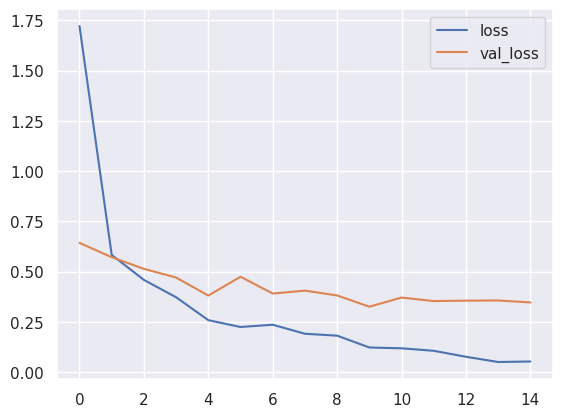

In [47]:
_ = pd.DataFrame(history.history)[['loss', 'val_loss']].plot()


We don't observe divergence, so this is a sign we didn't overfit

In [52]:
nn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d_94 (Conv2D)          (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 8)      0         
 2D)                                                             
                                                                 
 conv2d_95 (Conv2D)          (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 61504)             0

## 3.2. Αξιολόγηση




### 3.2.0 Βοηθητικές συναρτήσεις

For the model evaluation we define the following functions:
- `y_y_pred_from_ds` to get labels and predictions from dataset with a model
- `clf_report` to convert make the classification report string
- `clf_report_do_df` to convert the classification report string to a `DataFrame` for display purposes
- `confusion_matrix_report` to plot the confusion matrix and return it
- `stats_from_confusion_matrix` to calculate stats from the confusion matrix independently of the classification report

In [39]:
def y_y_pred_from_ds(ds, model):
    '''Get labels and predictions from dataset using model
       ds can be a dataset or a list of the form [X, y]
    '''
    if not isinstance(ds, list):
        y_pred, y = [], []
        for feature, label in ds:
            y_pred.extend(model.predict(feature))
            y.extend(label.numpy())
    else:
        X, y = ds
        y_pred = model.predict(X)

    # Transform labels to class names
    y = keras.utils.to_categorical(y, num_classes=NUM_CLASSES)
    y = [CLASS_NAMES[x] for x in np.argmax(y, axis=1)]
    y_pred = [CLASS_NAMES[x] for x in np.argmax(y_pred, axis=1)]
    return y, y_pred

In [33]:
def clf_report(model, subset, digits=5):
    '''Makes Classification Report and returns it'''
    
    import sklearn.metrics as metrics
    
    ds = DATASETS_DICT[subset] if isinstance(subset, str) else subset
    y, y_pred = y_y_pred_from_ds(ds, model)

    # Classification report
    return metrics.classification_report(
        y,
        y_pred,
        target_names=CLASS_NAMES,
        digits=digits
    )

In [34]:
def clf_report_to_df(txt):
    '''Convert classification report to DataFrame'''
    
    txt = txt.strip().replace('\n\n', '\n')
    txt = [ln.strip() for ln in txt.split('\n')]
    lines = []
    for ln in txt:
        if ln.startswith('accuracy'):
            line = ln.split()
            line.insert(1,'')
            line.insert(1,'')
        elif ln.startswith('precision'):
            line = ln.split()
            line.insert(0,'classes/agg')
        elif 'avg' in ln:
            line = ln.replace(' avg','-avg').split()
        else:
            line = ln.split()
        lines.append(line)
    
    return pd.DataFrame(data=lines[1:], columns=lines[0]).set_index('classes/agg')

In [35]:
def stats_from_confusion_matrix(cm):
    '''Calculate stats from Confusion Matrix'''

    import warnings
    warnings.filterwarnings('ignore')

    # Convert Confusion Matrix to DataFrame
    df = pd.DataFrame(cm, columns=CLASS_NAMES, index=CLASS_NAMES)
    df.columns.name = 'Predicted'
    df.index.name = 'Actual'
    
    # Accuracy
    acc = df.mul(np.eye(len(df))).sum().sum() / df.sum().sum()
    precisions, recalls, fscores = [], [], []
    print(f' Per Class '.center(50, '='))
    for cls in CLASS_NAMES:
        print(f'Class `{cls}`')
        tp = df.loc[cls,cls]            # Class TP
        fp = df.loc[:,cls].sum() - tp   # Class FP
        fn = df.loc[cls,:].sum() - tp   # Class FN
        # Class Precision
        try:
            pr = tp / (tp + fp)
        except:
            pr = 0
        else:
            if pd.isnull(pr):
                pr = 0
        # Class Recall
        try:
            rc = tp / (tp + fn)
        except:
            rc = 0
        else:
            if pd.isnull(rc):
                rc = 0
        # Class FScore
        try:                            
            1 / pr
            1 / rc
        except:
            fsc = 0
        else:
            fsc = 2 * pr * rc / (pr + rc)
            if pd.isnull(fsc):
                fsc = 0
        precisions.append(pr)
        recalls.append(rc)
        fscores.append(fsc)
        print(f'\tPrecision: {pr:.5f}')
        print(f'\tRecall: {rc:.5f}')
        print(f'\tFScore: {fsc:.5f}')
    print(f' Overall '.center(50, '='))
    print(f'Accuracy: {acc:.5f}')
    print(f'Precision: {sum(precisions)/len(precisions):.5f}')
    print(f'Recall: {sum(recalls)/len(recalls):.5f}')
    print(f'FScore: {sum(fscores)/len(fscores):.5f}')

In [36]:
def confusion_matrix_report(model, subset):
    '''plot Confusion Matrix and return it'''
    
    import sklearn.metrics as metrics
    
    ds = DATASETS_DICT[subset] if isinstance(subset, str) else subset
    y, y_pred = y_y_pred_from_ds(ds, model)

    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(6,4))
    ax.grid(False)
    cm = metrics.confusion_matrix(y, y_pred)
    cmp = metrics.ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
    cmp.plot(ax=ax, xticks_rotation=45)
    plt.show()
    return cm

### 3.2.1. ***Validation*** dataset

2/2 [==============================] - 0s 63ms/step


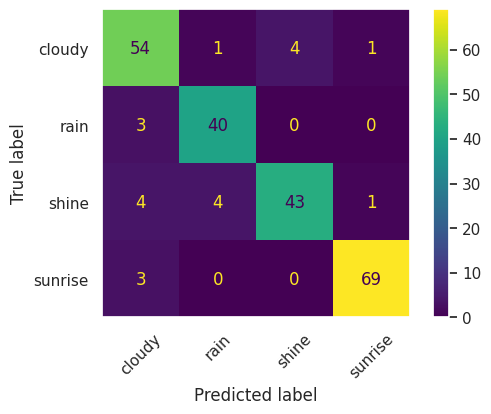

=================== Per Class ====================
Class `cloudy`
	Precision: 0.84375
	Recall: 0.90000
	FScore: 0.87097
Class `rain`
	Precision: 0.88889
	Recall: 0.93023
	FScore: 0.90909
Class `shine`
	Precision: 0.91489
	Recall: 0.82692
	FScore: 0.86869
Class `sunrise`
	Precision: 0.97183
	Recall: 0.95833
	FScore: 0.96503
==================== Overall =====================
Accuracy: 0.90749
Precision: 0.90484
Recall: 0.90387
FScore: 0.90345


In [48]:
stats_from_confusion_matrix(confusion_matrix_report(nn1, 'val'))

We can also calculate stats directly from `sklearn.metrics.classification_report`

In [50]:
clf_report_to_df(clf_report(nn1, 'val'))

2/2 [==============================] - 0s 7ms/step


,precision,recall,f1-score,support
classes/agg,,,,
cloudy,0.84375,0.90000,0.87097,60
rain,0.88889,0.93023,0.90909,43
shine,0.91489,0.82692,0.86869,52
sunrise,0.97183,0.95833,0.96503,72
accuracy,,,0.90749,227
macro-avg,0.90484,0.90387,0.90345,227
weighted-avg,0.90922,0.90749,0.90750,227


### 3.2.2. ***Test*** dataset

1/1 [==============================] - 0s 30ms/step


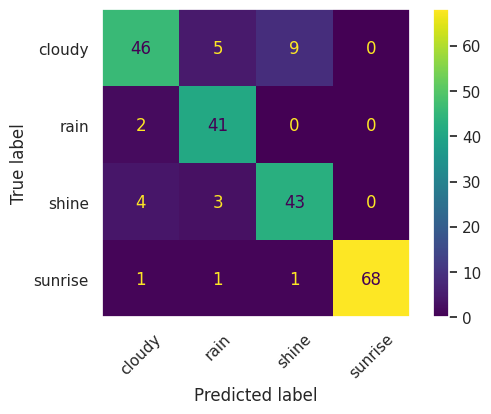

=================== Per Class ====================
Class `cloudy`
	Precision: 0.86792
	Recall: 0.76667
	FScore: 0.81416
Class `rain`
	Precision: 0.82000
	Recall: 0.95349
	FScore: 0.88172
Class `shine`
	Precision: 0.81132
	Recall: 0.86000
	FScore: 0.83495
Class `sunrise`
	Precision: 1.00000
	Recall: 0.95775
	FScore: 0.97842
==================== Overall =====================
Accuracy: 0.88393
Precision: 0.87481
Recall: 0.88448
FScore: 0.87731


In [49]:
stats_from_confusion_matrix(confusion_matrix_report(nn1, 'test'))

# 4. Συνελικτικό δίκτυο μεγάλου βάθους

In [51]:
nn2 = keras.Sequential(
    [
        # 1. Rescale an input to [0, 1]
        keras.layers.Rescaling(scale=1./255),
        # 2. 3x Conv2D 32, 3x3
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        # 3. MaxPooling step 4
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=4),
        # 4. 3x Conv2D 64, 3x3
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        # 5. MaxPooling step 2
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        # 6. 3x Conv2D 128, 3x3
        keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
        keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
        keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
        # 7. MaxPooling step 2
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        # 8. Flatten
        keras.layers.Flatten(),
        # 9. Fully connected
        keras.layers.Dense(units=128, activation='relu'),
        # 10. Output
        keras.layers.Dense(units=NUM_CLASSES, activation='softmax')
    ]
)

In [ ]:
history = compile_and_fit(nn2, train_ds, val_ds)

Epoch 1/20
11/11 [==============================] - 15s 429ms/step - loss: 1.1792 - accuracy: 0.4318 - val_loss: 0.8815 - val_accuracy: 0.5551
Epoch 2/20
11/11 [==============================] - 7s 429ms/step - loss: 0.9290 - accuracy: 0.5178 - val_loss: 0.9644 - val_accuracy: 0.5595
Epoch 3/20
11/11 [==============================] - 7s 417ms/step - loss: 0.8649 - accuracy: 0.5534 - val_loss: 0.8631 - val_accuracy: 0.5683
Epoch 4/20
11/11 [==============================] - 8s 551ms/step - loss: 0.8101 - accuracy: 0.6246 - val_loss: 0.8055 - val_accuracy: 0.5815
Epoch 5/20
11/11 [==============================] - 6s 369ms/step - loss: 0.7420 - accuracy: 0.6899 - val_loss: 0.7457 - val_accuracy: 0.6211
Epoch 6/20
11/11 [==============================] - 7s 421ms/step - loss: 0.6673 - accuracy: 0.7359 - val_loss: 0.6311 - val_accuracy: 0.7357
Epoch 7/20
11/11 [==============================] - 6s 383ms/step - loss: 0.6125 - accuracy: 0.7596 - val_loss: 0.5847 - val_accuracy: 0.7489
Epoch

In [ ]:
nn2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_114 (Conv2D)         (None, 254, 254, 32)      896       
                                                                 
 conv2d_115 (Conv2D)         (None, 252, 252, 32)      9248      
                                                                 
 conv2d_116 (Conv2D)         (None, 250, 250, 32)      9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_117 (Conv2D)         (None, 61, 61, 64)        18496     
                                                      

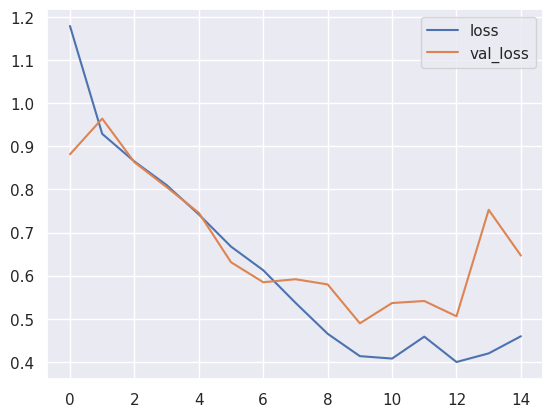

In [ ]:
_ = pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

We don't observe divergence, so this is a sign we didn't overfit

## 4.0 Αξιολόγηση

#### 4.0.1. ***Validation*** dataset

2/2 [==============================] - 0s 34ms/step


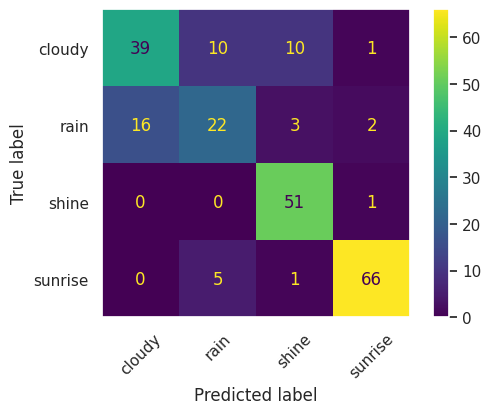

=================== Per Class ====================
Class `cloudy`
	Precision: 0.70909
	Recall: 0.65000
	FScore: 0.67826
Class `rain`
	Precision: 0.59459
	Recall: 0.51163
	FScore: 0.55000
Class `shine`
	Precision: 0.78462
	Recall: 0.98077
	FScore: 0.87179
Class `sunrise`
	Precision: 0.94286
	Recall: 0.91667
	FScore: 0.92958
==================== Overall =====================
Accuracy: 0.78414
Precision: 0.75779
Recall: 0.76477
FScore: 0.75741


In [ ]:
stats_from_confusion_matrix(confusion_matrix_report(nn2, 'val'))

#### 4.0.2. ***Test*** dataset

1/1 [==============================] - 0s 34ms/step


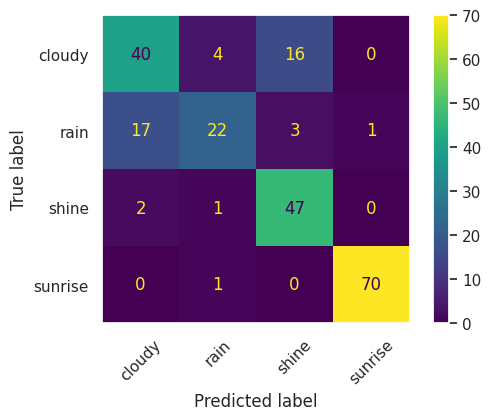

=================== Per Class ====================
Class `cloudy`
	Precision: 0.67797
	Recall: 0.66667
	FScore: 0.67227
Class `rain`
	Precision: 0.78571
	Recall: 0.51163
	FScore: 0.61972
Class `shine`
	Precision: 0.71212
	Recall: 0.94000
	FScore: 0.81034
Class `sunrise`
	Precision: 0.98592
	Recall: 0.98592
	FScore: 0.98592
==================== Overall =====================
Accuracy: 0.79911
Precision: 0.79043
Recall: 0.77605
FScore: 0.77206


In [ ]:
stats_from_confusion_matrix(confusion_matrix_report(nn2, 'test'))

# Σύγκριση 1

We observe bigger difference in accuracy between **train-validation** and **train-test** data in the simple model than in the deep one, but significantly better performance of the simple one on **test** data compared to the deep.

The better performance is maybe because it learns in a simpler way and can generalize better.

# 5. Προεκπαιδευμένο Νευρωνικό Δίκτυο

In [16]:
from keras.applications.inception_v3 import InceptionV3

Define a function to split `X` nd `y` from datasets

In [17]:
def split_X_y(ds):
    '''We need to create X and y in one run of ds if it is shuffled
       because each time it is exhausted it is reshuffled
       and if we do it separatelly we will have observation missmatches for X,y
    '''
    Xs, ys = [], []
    for X, y in ds.unbatch().take(-1):
        Xs.append(X.numpy())
        ys.append(y.numpy())
    return np.array(Xs), np.array(ys)

Seperate `X` from `y`

In [21]:
train_X, train_y = split_X_y(train_ds)
test_X, test_y = split_X_y(test_ds)
val_X, val_y = split_X_y(val_ds)

Scale input pixels between -1 and 1 as mentioned in the [docs](https://keras.io/api/applications/inceptionv3/)

In [22]:
train_X_pre = keras.applications.resnet50.preprocess_input(train_X.astype('float32'))
test_X_pre = keras.applications.resnet50.preprocess_input(test_X.astype('float32'))
val_X_pre = keras.applications.resnet50.preprocess_input(val_X.astype('float32'))

Define input shape as the one used for model training (`(299, 299, 3)` according to the [docs](https://keras.io/api/applications/inceptionv3/))

In [23]:
input_shape = (299, 299, 3)

In [24]:
inception_v3 = InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


- Freeze `InceptionV3`'s convolutional layers
- Resize input to our needs
- Add `GlobalAveragePooling2D` according to recommendation ([Fine-tune InceptionV3 on a new set of classes](https://keras.io/api/applications/#usage-examples-for-image-classification-models))

In [25]:
def make_pretrained(trainable=False):
    # Freeze all convolutional InceptionV3 layers according to `trainable`
    inception_v3.trainable = trainable

    # Resizing layer
    input = keras.Input(shape=train_X[0].shape)
    x = keras.layers.Resizing(*input_shape[:-1])(input)
    x = inception_v3(x)

    # Add GlobalAveragePooling
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Define output
    out = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return keras.Model(input, outputs=[out])

In [26]:
nn3 = make_pretrained()

In [28]:
history = compile_and_fit(nn3, train_X_pre, val_X_pre, train_y, val_y)

Epoch 1/20
11/11 [==============================] - 15s 1s/step - loss: 7.4583 - accuracy: 0.2849 - val_loss: 4.3693 - val_accuracy: 0.4229
Epoch 2/20
11/11 [==============================] - 4s 352ms/step - loss: 3.1595 - accuracy: 0.5193 - val_loss: 3.1166 - val_accuracy: 0.5595
Epoch 3/20
11/11 [==============================] - 4s 355ms/step - loss: 2.5511 - accuracy: 0.6261 - val_loss: 3.0206 - val_accuracy: 0.5991
Epoch 4/20
11/11 [==============================] - 4s 366ms/step - loss: 1.9413 - accuracy: 0.6573 - val_loss: 2.3013 - val_accuracy: 0.6167
Epoch 5/20
11/11 [==============================] - 4s 355ms/step - loss: 1.5446 - accuracy: 0.6973 - val_loss: 2.0015 - val_accuracy: 0.6784
Epoch 6/20
11/11 [==============================] - 4s 358ms/step - loss: 1.1592 - accuracy: 0.7478 - val_loss: 2.1397 - val_accuracy: 0.6300
Epoch 7/20
11/11 [==============================] - 4s 335ms/step - loss: 1.0297 - accuracy: 0.7507 - val_loss: 1.7767 - val_accuracy: 0.6872
Epoch 8/

In [29]:
nn3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_____________________________________________

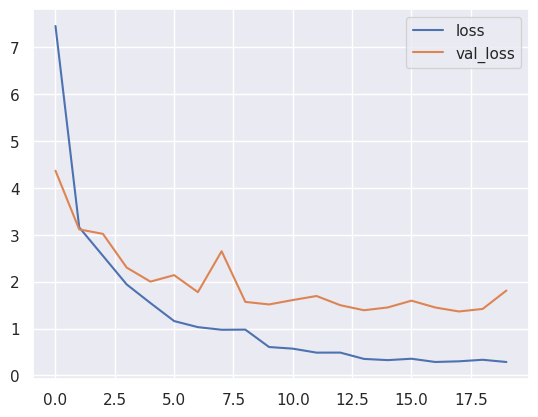

In [54]:
_ = pd.DataFrame(history.history)[['loss', 'val_loss']].plot()


We don't observe divergence, so this is a sign we didn't overfit

## 5.0 Αξιολόγηση

#### 5.0.1. ***Validation*** dataset

8/8 [==============================] - 1s 131ms/step


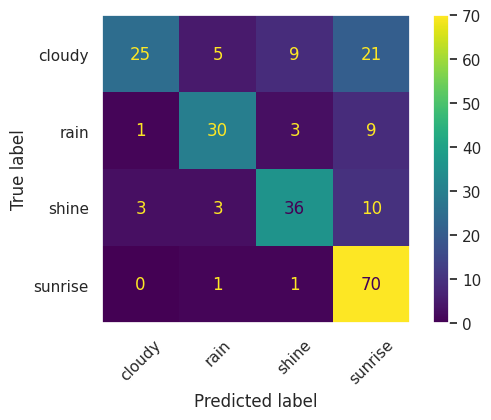

=================== Per Class ====================
Class `cloudy`
	Precision: 0.86207
	Recall: 0.41667
	FScore: 0.56180
Class `rain`
	Precision: 0.76923
	Recall: 0.69767
	FScore: 0.73171
Class `shine`
	Precision: 0.73469
	Recall: 0.69231
	FScore: 0.71287
Class `sunrise`
	Precision: 0.63636
	Recall: 0.97222
	FScore: 0.76923
==================== Overall =====================
Accuracy: 0.70925
Precision: 0.75059
Recall: 0.69472
FScore: 0.69390


In [40]:
stats_from_confusion_matrix(confusion_matrix_report(nn3, [val_X_pre, val_y]))

#### 5.0.2. ***Test*** dataset

7/7 [==============================] - 1s 124ms/step


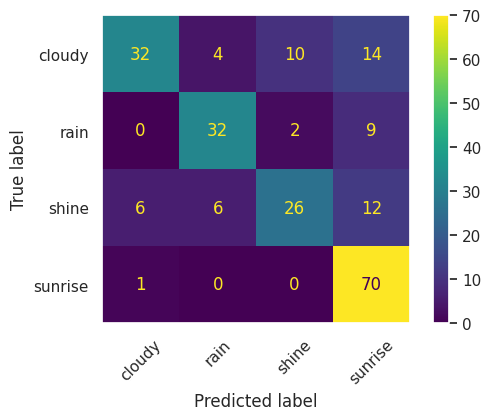

=================== Per Class ====================
Class `cloudy`
	Precision: 0.82051
	Recall: 0.53333
	FScore: 0.64646
Class `rain`
	Precision: 0.76190
	Recall: 0.74419
	FScore: 0.75294
Class `shine`
	Precision: 0.68421
	Recall: 0.52000
	FScore: 0.59091
Class `sunrise`
	Precision: 0.66667
	Recall: 0.98592
	FScore: 0.79545
==================== Overall =====================
Accuracy: 0.71429
Precision: 0.73332
Recall: 0.69586
FScore: 0.69644


In [41]:
stats_from_confusion_matrix(confusion_matrix_report(nn3, [test_X_pre, test_y]))

# Σύγκριση 2

The pre trained model has the biggest difference between **train-validation** and **train-test** sets, and the worst performance in the **test** data.

This can be a sign that simple models often discribe better the problem.

# Δοκιμή δικών σας εικόνων

In [55]:
MY_DATA_FLD_NAME = 'my-photos'

MY_DATA_FLD = get_dataset_fld(True, dataset_fld_name=MY_DATA_FLD_NAME)
print(MY_DATA_FLD)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/my-photos


In [56]:
MY_BATCH_SIZE = 1
MY_IMAGE_SIZE = (256, 256)

In [57]:
my_ds = tf.keras.utils.image_dataset_from_directory(
        directory=MY_DATA_FLD,
        shuffle=False,
        batch_size=MY_BATCH_SIZE,
        image_size=MY_IMAGE_SIZE
    )

Found 12 files belonging to 4 classes.


## Αξιολόγηση Απλού Συνελικτικού

1/1 [==============================] - 0s 18ms/step


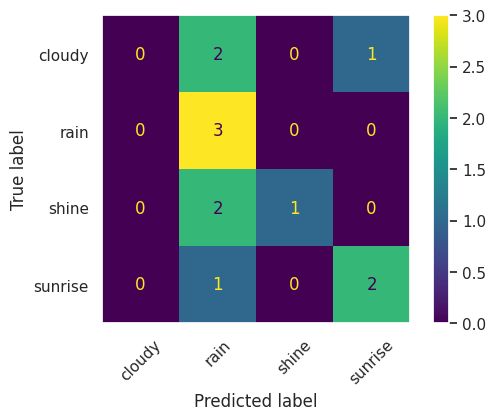

=================== Per Class ====================
Class `cloudy`
	Precision: 0.00000
	Recall: 0.00000
	FScore: 0.00000
Class `rain`
	Precision: 0.37500
	Recall: 1.00000
	FScore: 0.54545
Class `shine`
	Precision: 1.00000
	Recall: 0.33333
	FScore: 0.50000
Class `sunrise`
	Precision: 0.66667
	Recall: 0.66667
	FScore: 0.66667
==================== Overall =====================
Accuracy: 0.50000
Precision: 0.51042
Recall: 0.50000
FScore: 0.42803


In [58]:
stats_from_confusion_matrix(confusion_matrix_report(nn1, my_ds))

## Αξιολόγηση Συνελικτικού μεγάλου βάθους

1/1 [==============================] - 0s 20ms/step


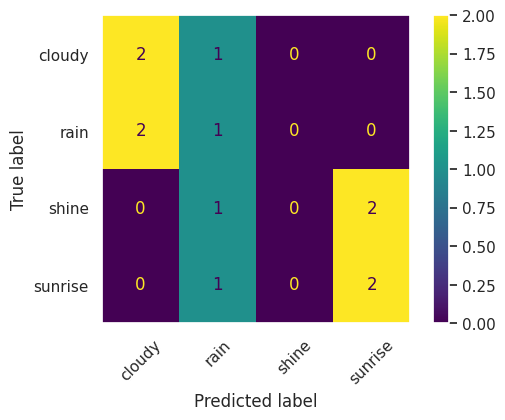

=================== Per Class ====================
Class `cloudy`
	Precision: 0.50000
	Recall: 0.66667
	FScore: 0.57143
Class `rain`
	Precision: 0.25000
	Recall: 0.33333
	FScore: 0.28571
Class `shine`
	Precision: 0.00000
	Recall: 0.00000
	FScore: 0.00000
Class `sunrise`
	Precision: 0.50000
	Recall: 0.66667
	FScore: 0.57143
==================== Overall =====================
Accuracy: 0.41667
Precision: 0.31250
Recall: 0.41667
FScore: 0.35714


In [59]:
stats_from_confusion_matrix(confusion_matrix_report(nn2, my_ds))

## Αξιολόγηση Προεκπαιδευμένου

Bring data to the form required by the model

In [61]:
my_X, my_y = split_X_y(my_ds)
my_X_pre = keras.applications.resnet50.preprocess_input(my_X.astype('float32'))

1/1 [==============================] - 2s 2s/step


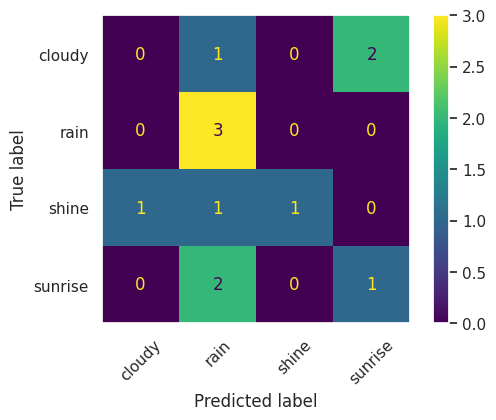

=================== Per Class ====================
Class `cloudy`
	Precision: 0.00000
	Recall: 0.00000
	FScore: 0.00000
Class `rain`
	Precision: 0.42857
	Recall: 1.00000
	FScore: 0.60000
Class `shine`
	Precision: 1.00000
	Recall: 0.33333
	FScore: 0.50000
Class `sunrise`
	Precision: 0.33333
	Recall: 0.33333
	FScore: 0.33333
==================== Overall =====================
Accuracy: 0.41667
Precision: 0.44048
Recall: 0.41667
FScore: 0.35833


In [62]:
stats_from_confusion_matrix(confusion_matrix_report(nn3, [my_X_pre, my_y]))

We observe that the model with the best performance is the simpler one, although still not good enough, since it raises accuracy just by 25% from random guess.

However, the predictions of each of the models on my photos are very different from the predictions they did one samples they had never seen (***test*** datasets), were they performed much better.

In order for the models to be trusted, they have to be tested again on more data they have never seen and compare performances.